# Loading all the required libraries and methods

In [1]:
#loading classes and packages
import pandas as pd
import numpy as np
import seaborn as sns
import shapely
import plotly.graph_objects as go
import plotly.express as px
color_pal=sns.color_palette()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from math import sqrt
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder


# Reading dataset

In [2]:
storm = pd.read_csv('StormEvents_2011_20230417.csv')
storm.describe()

,YEARMONTH,EPISODE_ID,EVENT_ID,LOCATION_INDEX,RANGE,latitude,longitude,LAT2,LON2
count,82199.000000,82199.000000,82199.000000,82199.000000,82199.000000,82199.000000,82199.000000,8.219900e+04,8.219900e+04
mean,201105.879524,52935.680860,317494.489556,1.800509,2.364191,38.410130,-88.732926,3.237342e+06,7.492267e+06
std,2.124492,3144.516826,21128.826005,1.304382,4.446157,4.781446,11.410928,1.367309e+06,3.192510e+06
min,201101.000000,45914.000000,266452.000000,1.000000,0.000000,-14.396900,-170.886800,-1.423814e+06,-1.445554e+07
25%,201104.000000,50328.000000,300110.500000,1.000000,0.570000,35.310000,-95.300000,3.244337e+06,7.544670e+06
50%,201106.000000,52577.000000,316753.000000,1.000000,1.290000,38.600000,-87.924100,3.723400e+06,8.511400e+06
75%,201107.000000,55291.000000,334854.500000,2.000000,2.730000,41.513300,-80.860000,4.051000e+06,9.333633e+06
max,201112.000000,79994.000000,479308.000000,8.000000,180.540000,66.914100,144.925700,6.654846e+06,1.705321e+07


# checking if there are any missing values

In [3]:
storm.isnull().sum()

YEARMONTH         0
EPISODE_ID        0
EVENT_ID          0
LOCATION_INDEX    0
RANGE             0
AZIMUTH           0
LOCATION          0
latitude          0
longitude         0
LAT2              0
LON2              0
dtype: int64

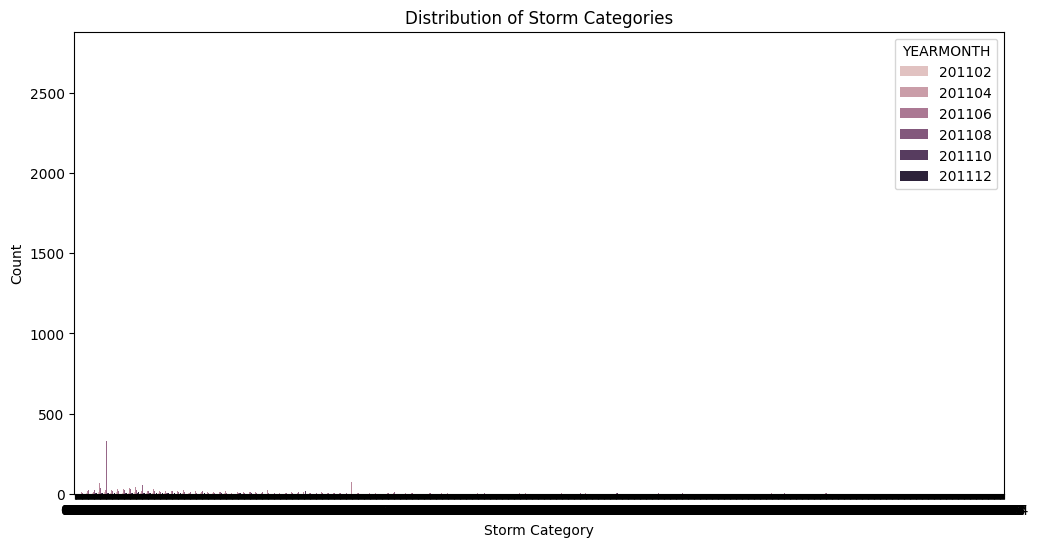

In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(x='RANGE', hue='YEARMONTH', data=storm)
plt.title('Distribution of Storm Categories')
plt.xlabel('Storm Category')
plt.ylabel('Count')
plt.show()

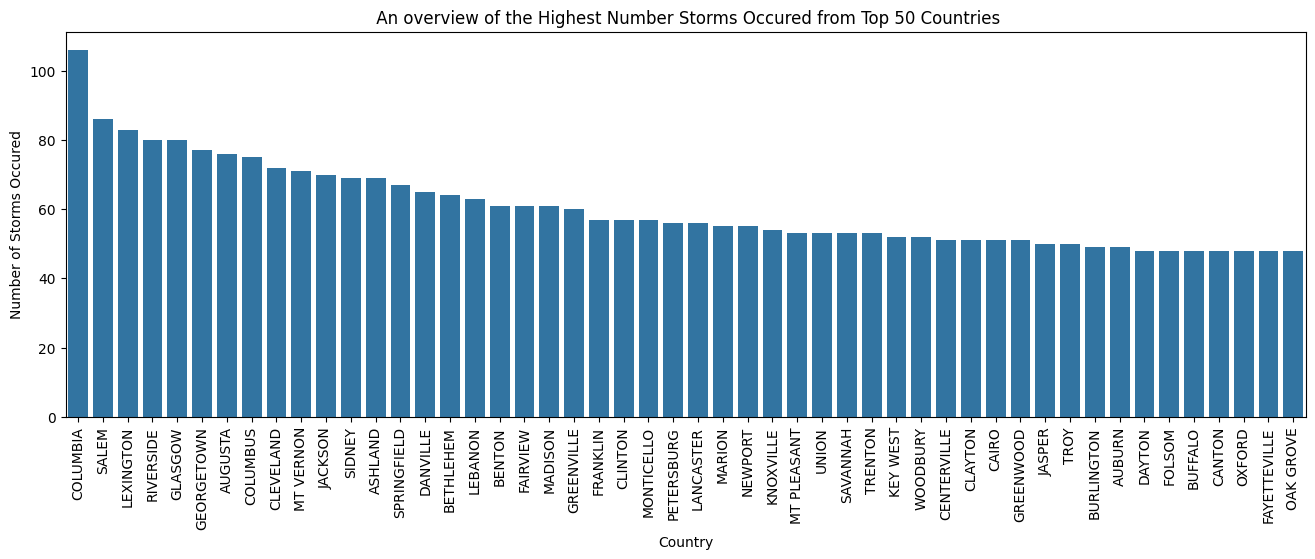

In [5]:
df = storm.groupby('LOCATION')['YEARMONTH'].count().sort_values(ascending=False).nlargest(50).reset_index()
plt.figure(figsize=(16,5))
df = df.values
temp = []
for i in range(len(df)):
    temp.append([df[i,0], df[i,1]])
temp = pd.DataFrame(temp, columns=['Country','Number of Storms Occured'])    
sns.barplot(x='Country',y='Number of Storms Occured', data=temp)
plt.title(' An overview of the Highest Number Storms Occured from Top 50 Countries')
plt.xticks(rotation=90)
plt.show()

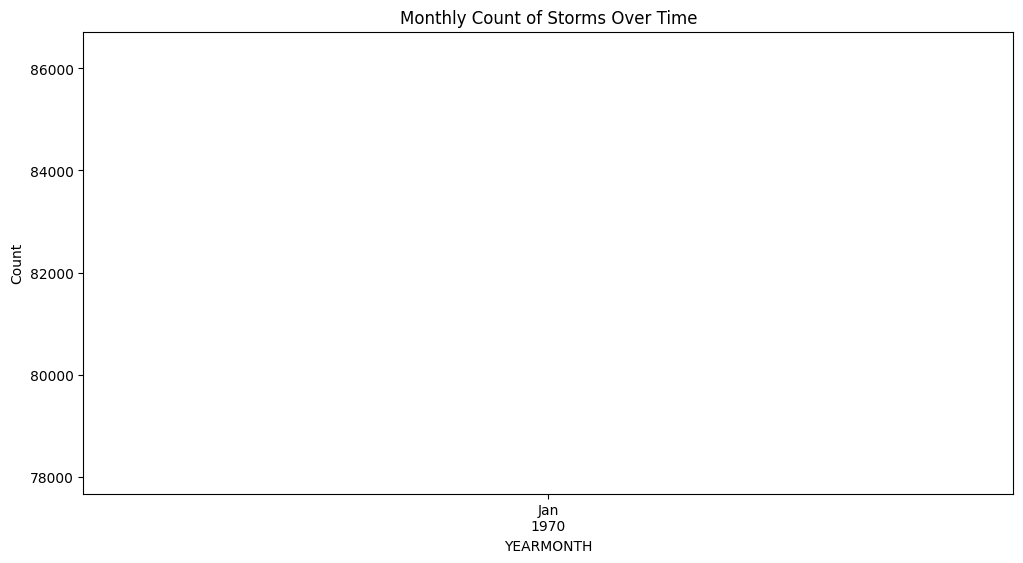

In [6]:
if 'YEARMONTH' in storm.columns:
    storm['YEARMONTH'] = pd.to_datetime(storm['YEARMONTH'])
    storm.set_index('YEARMONTH', inplace=True)

    # Example: Time series plot for the count of storms over time
    plt.figure(figsize=(12, 6))
    storm.resample('M').size().plot()
    plt.title('Monthly Count of Storms Over Time')
    plt.xlabel('YEARMONTH')
    plt.ylabel('Count')
    plt.show()
else:
    print("The 'YEARMONTH' column does not exist in the DataFrame.")

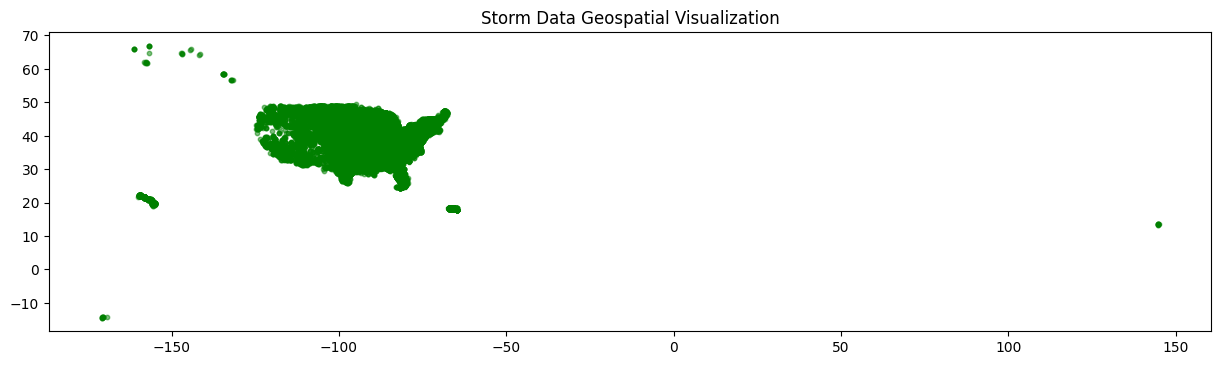

In [7]:
import geopandas as gpd

if 'longitude' in storm.columns and 'latitude' in storm.columns:
    # Assuming you have latitude and longitude columns in your dataset
    geometry = gpd.points_from_xy(storm['longitude'], storm['latitude'])
    geo_df = gpd.GeoDataFrame(storm, geometry=geometry)

    # Plotting on a map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    fig, ax = plt.subplots(figsize=(15, 10))
    geo_df.plot(ax=ax, markersize=10, color='green', alpha=0.5)
    plt.title('Storm Data Geospatial Visualization')
    plt.show()
else:
    print("The 'Longitude' and/or 'Latitude' columns do not exist in the DataFrame.")


# XG BOOST

In [8]:
# Features (X) and target variable (y)
X = storm[['longitude', 'latitude']]
y = storm['RANGE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert target variable to integer type using LabelEncoder for both y_train and y_test
label_encoder_train = LabelEncoder()
y_train_encoded = label_encoder_train.fit_transform(y_train)

label_encoder_test = LabelEncoder()
y_test_encoded = label_encoder_test.fit_transform(y_test)

# Standardize features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, y_train_encoded)

# Predictions and Evaluation
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb}')


XGBoost Accuracy: 0.016788321167883213


# K-Nearest Neighbors (KNN) Code

In [9]:
# Features (X) and target variable (y)
X = storm[['longitude', 'latitude']]
y = storm['RANGE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_linear)
print(f'Linear Regression Mean Squared Error: {mse}')


Linear Regression Mean Squared Error: 15.369314074739439


Linear Regression Mean Squared Error: 15.369314074739439
Coefficients: [-0.94250869  0.37808662]
Intercept: 2.3739048647333445


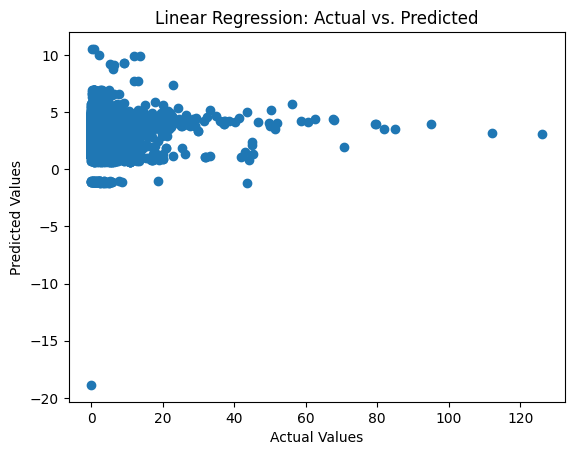

In [10]:
X = storm[['longitude', 'latitude']]
y = storm['RANGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred_linear)
print(f'Linear Regression Mean Squared Error: {mse}')
print('Coefficients:', linear_model.coef_)
print('Intercept:', linear_model.intercept_)
plt.scatter(y_test, y_pred_linear)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs. Predicted')
plt.show()

# Support Vector Machine (SVM)

In [12]:
# Drop rows with NaN values
storm = storm.dropna()

# Features (X) and target variable (y)
X = storm[['longitude', 'latitude']]
y = storm['RANGE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Support Vector Machine (SVM) for regression
svm_model = SVR()
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# Print the predicted values
print('Predicted Values:', y_pred_svm)


Predicted Values: [1.84233442 1.17465718 0.91525573 ... 3.12755758 0.87715467 1.69933529]
